## Train LSTM & RNN
#### Data preparation note
Stack short sequences ffrom many road segments together. Short sequences are obtained by breaking long time series into overlapping windows
 
|Shape | Meaning |
|------|---------|
|X_train: (N, seq_len, n_features)|N = total number of sequences across all TMCs|
|y_train: (N,)|Next-step travel time for each sequence|
|Optional tmc_id|To track which segment each sample came from|

#### Note
- log-transform target to log_tt_per_mile, model converges too fast, results flat prediction

##

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss

In [20]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))
print(X_full.columns)

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 26)
Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_cat_unplanned',
       'evt_cat_planned', 'miles', 'onramp', 'offramp', 'curve', 'evt_total',
       'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week',
       'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend', 'lag1', 'lag2',
       'lag3', 'tt_per_mile', 'lag1_tt_per_mile', 'lag2_tt_per_mile',
       'lag3_tt_per_mile', 'speed_ratio'],
      dtype='object')


In [24]:
X_full.head()

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 03:00:00+00:00  71.933333               7.4110   
          2025-06-16 04:00:00+00:00  71.816667               7.4220   
          2025-06-16 05:00:00+00:00  71.066667               7.4975   
          2025-06-16 06:00:00+00:00  71.550000               7.4455   
          2025-06-16 07:00:00+00:00  70.516667               7.5555   

                                     reference_speed  evt_cat_unplanned  \
tmc_code  time_bin                                                        
115+04177 2025-06-16 03:00:00+00:00             70.0                  0   
          2025-06-16 04:00:00+00:00             70.0                  0   
          2025-06-16 05:00:00+00:00             70.0                  0   
          2025-06-16 06:00:00+00:00             70.0                  0   
          2025-06-16 07:00:00+00:00             70.0                  0   

                                     evt_cat_planned     miles  onramp  \
tmc_code  time_bin                                                       
115+04177 2025-06-16 03:00:00+00:00                0  0.147902       0   
          2025-06-16 04:00:00+00:00                0  0.147902       0   
          2025-06-16 05:00:00+00:00                0  0.147902       0   
          2025-06-16 06:00:00+00:00                0  0.147902       0   
          2025-06-16 07:00:00+00:00                0  0.147902       0   

                                     offramp  curve  evt_total  ...  \
tmc_code  time_bin                                              ...   
115+04177 2025-06-16 03:00:00+00:00        0      0          0  ...   
          2025-06-16 04:00:00+00:00        0      0          0  ...   
          2025-06-16 05:00:00+00:00        0      0          0  ...   
          2025-06-16 06:00:00+00:00        0      0          0  ...   
          2025-06-16 07:00:00+00:00        0      0          0  ...   

                                     hour_of_week_cos  is_weekend      lag1  \
tmc_code  time_bin                                                            
115+04177 2025-06-16 03:00:00+00:00          0.993712           0  7.950667   
          2025-06-16 04:00:00+00:00          0.988831           0  7.411000   
          2025-06-16 05:00:00+00:00          0.982566           0  7.422000   
          2025-06-16 06:00:00+00:00          0.974928           0  7.497500   
          2025-06-16 07:00:00+00:00          0.965926           0  7.445500   

                                         lag2      lag3  tt_per_mile  \
tmc_code  time_bin                                                     
115+04177 2025-06-16 03:00:00+00:00  7.665000  7.598167    50.107505   
          2025-06-16 04:00:00+00:00  7.950667  7.665000    50.181878   
          2025-06-16 05:00:00+00:00  7.411000  7.950667    50.692351   
          2025-06-16 06:00:00+00:00  7.422000  7.411000    50.340767   
          2025-06-16 07:00:00+00:00  7.497500  7.422000    51.084503   

                                     lag1_tt_per_mile  lag2_tt_per_mile  \
tmc_code  time_bin                                                        
115+04177 2025-06-16 03:00:00+00:00         53.756317         51.824858   
          2025-06-16 04:00:00+00:00         50.107505         53.756317   
          2025-06-16 05:00:00+00:00         50.181878         50.107505   
          2025-06-16 06:00:00+00:00         50.692351         50.181878   
          2025-06-16 07:00:00+00:00         50.340767         50.692351   

                                     lag3_tt_per_mile  speed_ratio  
tmc_code  time_bin                                                  
115+04177 2025-06-16 03:00:00+00:00         51.372982     1.027619  
          2025-06-16 04:00:00+00:00         51.824858     1.025952  
          2025-06-16 05:00:00+00:00         53.756317     1.015238  
          2025-06-16 06:00:00+00:00         50.107505     1.022143  
 

In [ ]:
# Full training pipeline
class LogSpaceMSE(Loss):
    def call(self, y_true, y_pred):
        y_true_log = tf.math.log(y_true + 1e-6)
        y_pred_log = tf.math.log(y_pred + 1e-6)
        # print(y_true_log, y_pred_log)
        return tf.reduce_mean(tf.square(y_true_log - y_pred_log))
    
def train_lstm(X_full, feature_cols, target_col, seq_len=6, stride=1,
               test_frac=0.2, hidden_units=64, dropout=0.2,
               batch_size=128, epochs=100, shuffle_train=True):
    """
    Full LSTM training pipeline:
      - Creates sliding window sequences across all TMCs
      - Chronologically splits into train/test by time (last test_frac fraction)
      - Uses internal normalization layer (acts like StandardScaler)
      - Trains and evaluates the LSTM

    Args:
        X_full (DataFrame): indexed by (tmc_code, time_bin)
        feature_cols (list): feature column names
        target_col (str): target column
        seq_len (int): lookback window
        stride (int): sliding window stride
        test_frac (float): fraction of data for test (chronological)
        shuffle_train (bool): whether to shuffle training samples
    """

    # === 1. Build sequences ===
    print("Preparing sequence data...")
    Xs, ys, meta = [], [], []
    for tmc, grp in X_full.groupby(level='tmc_code'):
        grp = grp.sort_index(level='time_bin')
        data = grp[feature_cols + [target_col]].to_numpy()
        times = grp.index.get_level_values('time_bin').to_numpy()

        for start in range(0, len(data) - seq_len, stride):
            Xs.append(data[start:start + seq_len, :-1])
            ys.append(data[start + seq_len, -1])
            meta.append((tmc, times[start + seq_len]))

    Xs = np.stack(Xs)
    ys = np.array(ys)
    meta = pd.DataFrame(meta, columns=['tmc_code', 'time_bin'])

    print(f"Generated {len(Xs)} total sequences from {X_full.index.get_level_values('tmc_code').nunique()} TMCs")

    # === 2. Chronological split (global, not per TMC) ===
    print("Splitting data chronologically per TMC...")

    train_idx, test_idx = [], []
    for tmc, grp in meta.groupby('tmc_code', sort=False):
        grp_sorted = grp.sort_values('time_bin')
        n = len(grp_sorted)
        n_test = max(1, int(n * test_frac))
        train_idx.extend(grp_sorted.index[:-n_test].tolist())
        test_idx.extend(grp_sorted.index[-n_test:].tolist())

    X_train, X_test = Xs[train_idx], Xs[test_idx]
    y_train, y_test = ys[train_idx], ys[test_idx]
    meta_train = meta.loc[train_idx].reset_index(drop=True)
    meta_test = meta.loc[test_idx].reset_index(drop=True)

    # === 3. Shuffle training samples (after splitting, not time-wise) ===
    if shuffle_train:
        idx = np.arange(len(X_train))
        np.random.shuffle(idx)
        X_train, y_train = X_train[idx], y_train[idx]
        meta_train = meta_train.iloc[idx].reset_index(drop=True)

    n_features = X_train.shape[2]

    # === 4. Build model with internal normalization layer ===
    print("Building LSTM model with normalization...")
    # Adapt normalization on training data
    normalizer = Normalization(axis=-1)
    normalizer.adapt(X_train.reshape(-1, n_features))  # <- works, not yet bound to input shape

    model = Sequential([
        Input(shape=(seq_len, n_features)),
        normalizer,
        LSTM(hidden_units, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
        # Dense(1, activation='softplus')  # ensure non-negative output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # === 5. Train model with random validation split ===
    n_val = int(0.2 * len(X_train))
    X_val, y_val = X_train[-n_val:], y_train[-n_val:]
    X_train_sub, y_train_sub = X_train[:-n_val], y_train[:-n_val]

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,  # shuffle again for each epoch
        callbacks=[es],
        verbose=1
    )

    # === 6. Evaluate ===
    print("Evaluating model...")
    y_pred = model.predict(X_test).squeeze()
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    mae  = np.mean(np.abs(y_test - y_pred))
    print(f"Test RMSE: {rmse:.3f}, MAE: {mae:.3f}")

    return model, history, (X_train, y_train, X_test, y_test, y_pred, meta_train, meta_test) # X_test, y_test, and y_pred still remain chronological order

In [4]:
# Simple LSTM model
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_unplanned', 'evt_cat_planned']
# lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
lag_features = ['lag1_tt_per_mile', 'lag2_tt_per_mile', 'lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + lag_features + tmc_features

SEQ_LEN = 24          # past X hours → predict next hour
STRIDE = 1           # sliding window stride
TARGET_COL = 'tt_per_mile'
FEATURE_COLS = full_features
model, history, (X_train, y_train, X_test, y_test, y_pred, meta_train, meta_test) = train_lstm(X_full, FEATURE_COLS, TARGET_COL, seq_len=SEQ_LEN, shuffle_train=True)

Preparing sequence data...
Generated 117500 total sequences from 50 TMCs
Splitting data chronologically per TMC...
Building LSTM model with normalization...
Epoch 1/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 305.4160 - mae: 9.4107 - val_loss: 19.9251 - val_mae: 1.4078
Epoch 2/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 40.5029 - mae: 3.1873 - val_loss: 19.5630 - val_mae: 1.3475
Epoch 3/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 39.3114 - mae: 3.1237 - val_loss: 17.7272 - val_mae: 1.2799
Epoch 4/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 37.6443 - mae: 3.0955 - val_loss: 16.9627 - val_mae: 1.3935
Epoch 5/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 37.1233 - mae: 3.0825 - val_loss: 16.5314 - val_mae: 1.2328
Epoch 6/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 36.5211 - mae: 3.0544 - val_loss: 17.3661 - val_mae: 1.8732
Epoch 7/100
661/661 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 36.1453 - mae: 3.0301 - val_loss: 16.0209 - val_mae: 1.

In [5]:
# get training and testing error
train_rmse = np.sqrt(np.mean((y_train - model.predict(X_train).squeeze())**2))
test_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")

2938/2938 ━━━━━━━━━━━━━━━━━━━━ 3s 923us/step
Train RMSE: 4.221, Test RMSE: 8.876


In [11]:
X_train.shape # (94000, 24, 17) N x seq_len x n_features
# y_test.shape # (23500,) #N = total number of sequences across all TMCs
# y_train.shape # (94000,)

(94000, 24, 17)

In [15]:
tmc_order_dict = {
    'WB': ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184', '115P04183', '115+04183', '115P04182', '115+04182', '115P04181', '115+04181', '115P04180', '115+04180', '115P04179', '115+04179', '115P04178', '115+04178', '115P04177', '115+04177', '115P05165'],
    'EB': ['115N04188', '115-04187', '115N04187', '115-04186', '115N04186', '115-04185', '115N04185', '115-04184', '115N04184', '115-04183', '115N04183', '115-04182', '115N04182', '115-04181', '115N04181', '115-04180', '115N04180', '115-04179', '115N04179', '115-04178', '115N04178', '115-04177', '115N04177', '115-05165', '115N05165']
}
time_index = sorted(X_full.index.get_level_values('time_bin').unique())
tmc_order = tmc_order_dict['WB']

train_df = (
    meta_train.assign(y_true=y_train, y_pred=model.predict(X_train).squeeze())
            .query("tmc_code in @tmc_order") # change query to be a list of tmc_order
            .sort_values(['tmc_code', 'time_bin'])            # now respects your order
            .reset_index(drop=True)
)
test_df = (
    meta_test.assign(y_true=y_test, y_pred=y_pred)
            .query("tmc_code in @tmc_order")
            .sort_values(['tmc_code', 'time_bin'])            # now respects your order
            .reset_index(drop=True)
)

# Concatenate for continuous timeline
full_df = pd.concat([train_df.assign(split='Train'),
                    test_df.assign(split='Test')],
                    ignore_index=True)
full_df

2938/2938 ━━━━━━━━━━━━━━━━━━━━ 3s 914us/step


,tmc_code,time_bin,y_true,y_pred,split
0,115+04177,2025-06-17 03:00:00+00:00,50.563888,52.754211,Train
1,115+04177,2025-06-17 04:00:00+00:00,50.414014,50.577309,Train
2,115+04177,2025-06-17 05:00:00+00:00,50.048907,50.464108,Train
3,115+04177,2025-06-17 06:00:00+00:00,50.961674,51.125732,Train
4,115+04177,2025-06-17 07:00:00+00:00,51.031540,51.694473,Train
...,...,...,...,...,...
58745,115P05165,2025-09-22 20:00:00+00:00,51.381306,51.103764,Test
58746,115P05165,2025-09-22 21:00:00+00:00,50.424683,50.616005,Test
58747,115P05165,2025-09-22 22:00:00+00:00,50.276565,50.933601,Test
58748,115P05165,2025-09-22 23:00:00+00:00,51.096193,50.827194,Test


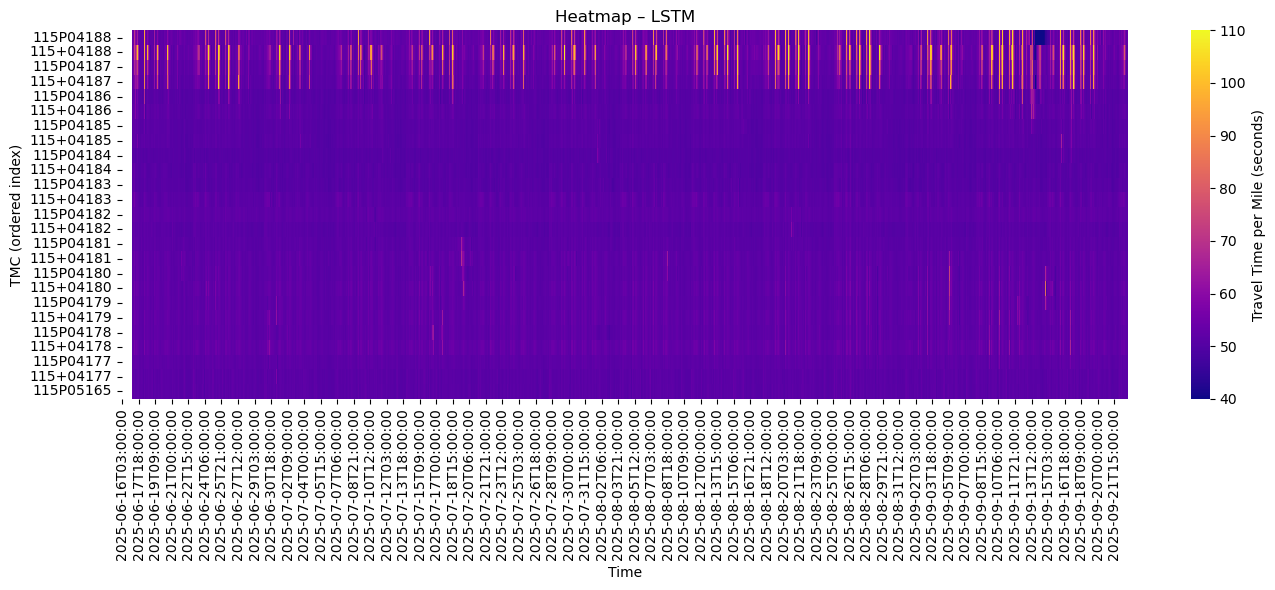

In [19]:
# plot heatmap of prediction
import i10_models as m

# Pivot to 2D table
preds_2d = (
    full_df.pivot(index='tmc_code', columns='time_bin', values='y_pred')
    .reindex(index=tmc_order, columns=time_index)   # enforce custom order
).to_numpy().T

# Plot heatmap of predictions
_=m.plot_heatmap_travel_time(
    preds=preds_2d,
    time_index=time_index,
    tmc_order=tmc_order,
    title="Heatmap – LSTM",
    cmap='plasma',
    vmin=40, vmax=110
)

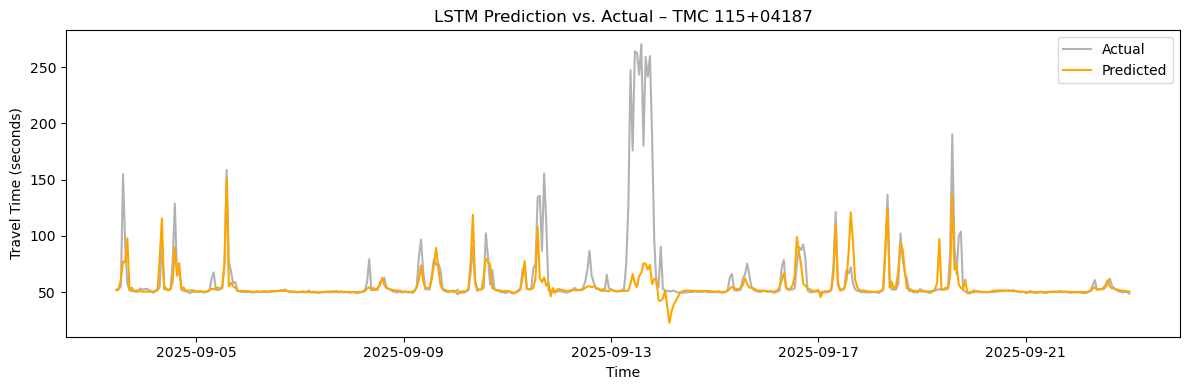

In [33]:
TMC = "115+04187"
tmc_results = (
    meta_test.assign(y_true=y_test, y_pred=y_pred)
             .query("tmc_code == @TMC")
             .sort_values('time_bin')
             .reset_index(drop=True)
)

plt.figure(figsize=(12, 4))
plt.plot(tmc_results['time_bin'], tmc_results['y_true'],
         label='Actual', color='gray', alpha=0.6)
plt.plot(tmc_results['time_bin'], tmc_results['y_pred'],
         label='Predicted', color='orange')
plt.title(f"LSTM Prediction vs. Actual – TMC {TMC}")
plt.xlabel("Time")
plt.ylabel("Travel Time (seconds)")
plt.legend()
plt.tight_layout()
plt.show()

2938/2938 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step


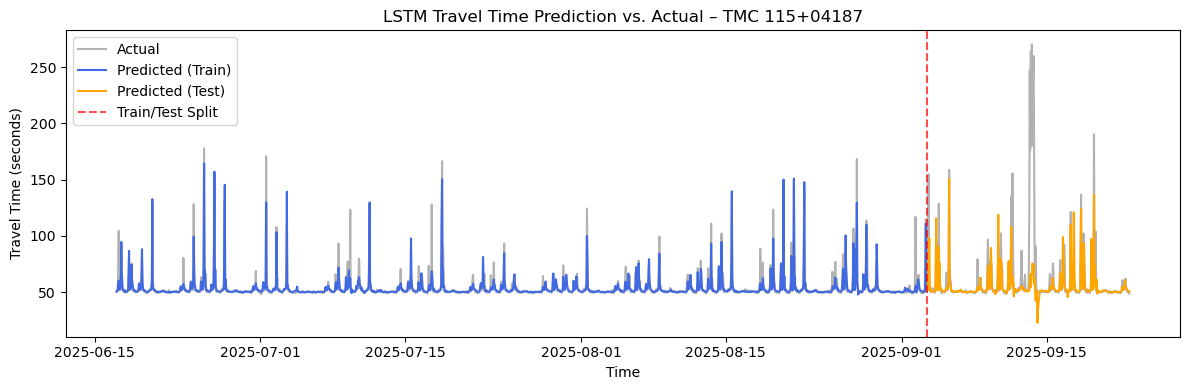

In [34]:

# TMC = "115+04177"

# Combine training and testing results with true + predicted
train_df = (
    meta_train.assign(y_true=y_train, y_pred=model.predict(X_train).squeeze())
              .query("tmc_code == @TMC")
              .sort_values('time_bin')
              .reset_index(drop=True)
)

test_df = (
    meta_test.assign(y_true=y_test, y_pred=y_pred)
             .query("tmc_code == @TMC")
             .sort_values('time_bin')
             .reset_index(drop=True)
)

# Concatenate for continuous timeline
full_df = pd.concat([train_df.assign(split='Train'),
                     test_df.assign(split='Test')],
                    ignore_index=True)

plt.figure(figsize=(12, 4))

# Plot actuals
plt.plot(full_df['time_bin'], full_df['y_true'],
         label='Actual', color='gray', alpha=0.6)

# Plot in-sample (training) predictions
plt.plot(train_df['time_bin'], train_df['y_pred'],
         label='Predicted (Train)', color='royalblue')

# Plot out-of-sample (testing) predictions
plt.plot(test_df['time_bin'], test_df['y_pred'],
         label='Predicted (Test)', color='orange')

# Vertical line separating train/test boundary
plt.axvline(x=test_df['time_bin'].min(),
            color='red', linestyle='--', alpha=0.7, label='Train/Test Split')

plt.title(f"LSTM Travel Time Prediction vs. Actual – TMC {TMC}")
plt.xlabel("Time")
plt.ylabel("Travel Time (seconds)")
plt.legend()
plt.tight_layout()
plt.show()

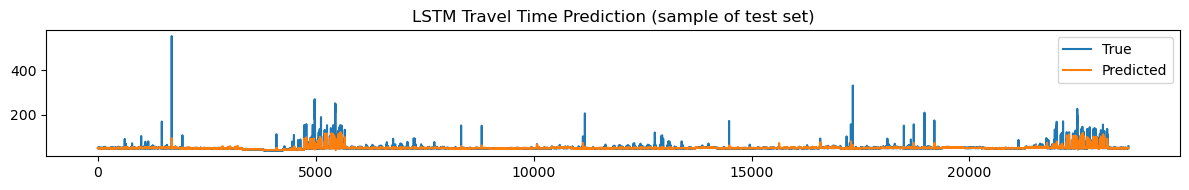

In [29]:
plt.figure(figsize=(12,2))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Travel Time Prediction (sample of test set)')
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# save the trained model
import os

def save_training_outputs(
    model, history,
    X_train, y_train, X_test, y_test, y_pred,
    meta_train, meta_test,
    save_dir="../models/lstm_outputs"
):
    os.makedirs(save_dir, exist_ok=True)

    # === 1. Save model ===
    model_path = os.path.join(save_dir, "model.keras")
    model.save(model_path)
    print(f"✅ Model saved to {model_path}")

    # # === 2. Save training history ===
    # hist_path = os.path.join(save_dir, "training_history.json")
    # with open(hist_path, "w") as f:
    #     json.dump(history.history, f)
    # print(f"✅ Training history saved to {hist_path}")

    # === 3. Save arrays ===
    npz_path = os.path.join(save_dir, "results.npz")
    np.savez_compressed(
        npz_path,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        y_pred=y_pred
    )
    print(f"✅ Data arrays saved to {npz_path}")

    # === 4. Save metadata ===
    meta_train.to_parquet(os.path.join(save_dir, "meta_train.parquet"))
    meta_test.to_parquet(os.path.join(save_dir, "meta_test.parquet"))
    print(f"✅ Metadata saved to Parquet format")

    print(f"\nAll outputs saved in: {os.path.abspath(save_dir)}")

save_training_outputs(
    model, history,
    X_train, y_train, X_test, y_test, y_pred,
    meta_train, meta_test,
    save_dir="../models/lstm_outputs"
)

✅ Model saved to ../models/lstm_outputs/model.keras
✅ Data arrays saved to ../models/lstm_outputs/results.npz
✅ Metadata saved to Parquet format

All outputs saved in: /Users/ywan1649/Documents/03_Research/Active/wzdx/models/lstm_outputs


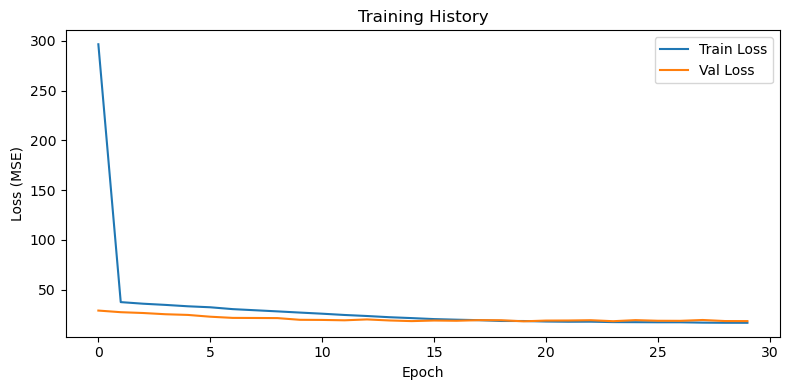

In [31]:
# plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
X_full.columns

Index(['speed', 'travel_time_seconds', 'reference_speed', 'evt_duration',
       'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure',
       'evt_cat_obstruction', 'evt_cat_misc', 'miles', 'hour_sin', 'hour_cos',
       'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin',
       'hour_of_week_cos', 'is_weekend', 'evt_total', 'speed_ratio', 'lag1',
       'lag2', 'lag3', 'tt_per_mile', 'lag1_tt_per_mile', 'lag2_tt_per_mile',
       'lag3_tt_per_mile'],
      dtype='object')